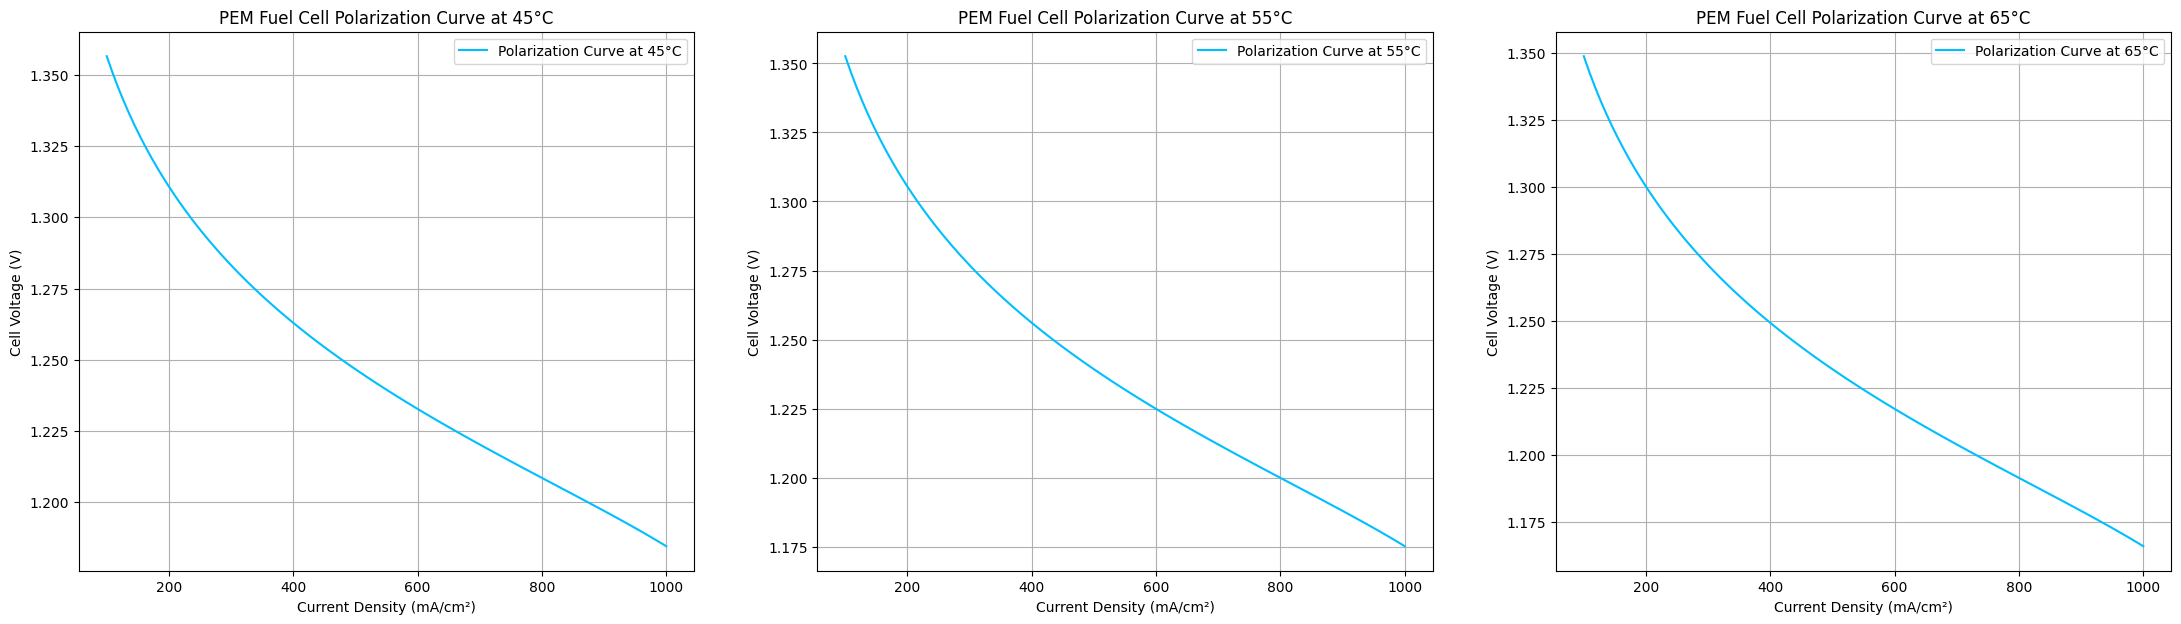

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# Constants and parameters (defined from the prompt)
P_anode = 700  # Anode pressure (mbar)
lambda_air = 1.5  # Air excess ratio
P_air = 1.35  # Air compressor pressure ratio at 400 A (open throttle valve)
F = 96485  # Faraday constant (C/mol)
R = 8.314  # Universal gas constant (J/mol/K)
A = 0.0002045  # V/K (activation losses)
B = 4.308e-05  # V/K (concentration losses)
M = 2.01e-07  # kOhm*cm^2 (ohmic losses)
N = 1924.99  # K (ohmic losses)
i_L = 1.2  # Limiting current density (A/cm^2)
n_cells = 96  # Number of cells in the stack (from the paper)
A_cell = 0.0409  # m² (409 cm² cell area from paper)
Uf_target = 0.8  # Target fuel utilization = 80%
H2_pump_speed = 4000 # RPM  (Not directly used in calculations, but kept for context)
Ambient_Temperature = 20 + 273 #K (Not directly used in calculations, but kept for context)
Relative_humidity = 45/100 #45% relative humidity (Not directly used in calculations, but kept for context)

# Physical Constants
R_H2 = 8.314
M_H2 = 0.002016

# Units conversion and scaling, current range is now for entire stack
#current_range = np.linspace(120, 400, 100)  # A, Total stack current
P_anode = P_anode * 100  # Pa
P_air = P_air * 100000 #Pa
#current_density_range = current_range/(A_cell*10000) #Current Density Calculation

# Define temperature range
temperatures = [45 + 273.15, 55 + 273.15, 65 + 273.15]  # K

# Stoichiometric coefficient for hydrogen in the fuel cell reaction
n_H2 = 2  # 2 moles of H2 per mole of O2


# Stack pressure drop (empirical fit from paper)
def pdrop_stack(i, lambda_air):
    return 27.49 + 2.832 * i - 16.2 * lambda_air - 0.007953 * i**2 + 0.7361 * i * lambda_air

# Oxygen partial pressure
def oxygen_partial_pressure(p, pdrop_stack, l):
    return 0.21 * (p - pdrop_stack / 2) * (1 + (1 / l - 1) / l) ** 2

# Nernst voltage
def nernst_voltage(T, P_O2):
    E0 = 1.229
    Tref = 298.15
    pref = 0.21 * 1e5  # Reference oxygen partial pressure in Pa
    return E0 - 8.5e-4 * (T - Tref) + 4.3085e-5 * T * np.log(P_O2 / pref)

# Activation loss
def activation_loss(i, T):
    return A * T * np.log(i + 2e-3)

# Ohmic loss
def ohmic_loss(i, T):
    r_ohm = M * np.exp(-N / T)
    return i * r_ohm

# Concentration loss
def concentration_loss(i, T):
    return B * T * np.log(i_L / (i_L - i))

# Fuel Flow Rate Calculation
def calculate_fuel_flow_rate(I, T, P_H2):
    """
    Calculates the hydrogen fuel flow rate (molar and mass) required for the fuel cell reaction.
    """
    # I is the stack current (in Amperes)
    # n_cells is the number of cells in the stack
    # n_H2 is the number of moles of hydrogen consumed per mole of electrons (stoichiometry)
    # F is Faraday's constant

    # Calculate molar flow rate of hydrogen (mol/s)
    molar_flow_rate = (n_cells * I) / (n_H2 * F)

    # Ideal gas law to convert molar flow rate to volumetric flow rate (m^3/s)
    volumetric_flow_rate = (molar_flow_rate * R_H2 * T) / P_H2

    # Calculate mass flow rate of hydrogen (kg/s)
    mass_flow_rate = molar_flow_rate * M_H2

    return molar_flow_rate, mass_flow_rate, volumetric_flow_rate

# Oxygen Flow Rate Calculation
def calculate_oxygen_flow_rate(I, T, P_air):
    """
    Calculates the oxygen flow rate (molar and mass) required for the fuel cell reaction.
    """
    # I is the stack current (in Amperes)
    # n_cells is the number of cells in the stack
    # F is Faraday's constant

    # Number of moles of oxygen consumed per mole of electrons (stoichiometry)
    n_O2 = 1  # O2 + 4e- + 4H+ -> 2H2O

    # Calculate molar flow rate of oxygen (mol/s)
    molar_flow_rate = (n_cells * I) / (4 * F)

    # Ideal gas law to convert molar flow rate to volumetric flow rate (m^3/s)
    volumetric_flow_rate = (molar_flow_rate * R * T) / (0.21 * P_air)  # O2 is ~21% of air

    # Molar mass of Oxygen (kg/mol)
    M_O2 = 0.032  # kg/mol

    # Calculate mass flow rate of oxygen (kg/s)
    mass_flow_rate = molar_flow_rate * M_O2

    return molar_flow_rate, mass_flow_rate, volumetric_flow_rate


def calculate_fuel_utilization(I, hydrogen_flow_rate):
    """
    Calculate fuel utilization based on the actual hydrogen flow rate and the stoichiometric
    hydrogen consumption.
    """
    # Actual hydrogen consumption from the reaction
    stoichiometric_flow_rate = (n_cells * I) / (2 * F) # Molar flow rate

    # Fuel utilization calculation
    fuel_utilization = stoichiometric_flow_rate / hydrogen_flow_rate
    return fuel_utilization


# Temperature range
temperatures = [45+273.15, 55+273.15, 65+273.15]  # 45, 55, 65°C in Kelvin

# Prepare figure for plotting
fig, axs = plt.subplots(1, len(temperatures), figsize=(27, 7))  # Adjust figure height dynamically
plt.subplots_adjust(hspace=0.5)  # Adjust vertical space

# Loop through each temperature and perform calculations
for idx, T in enumerate(temperatures):
    # Calculate stack pressure drop and O2 partial pressure
    pdrop = pdrop_stack(current_density, lambda_air)
    P_O2 = oxygen_partial_pressure(P_air, pdrop, lambda_air)
    E_OC = nernst_voltage(T, P_O2)
    V_act = activation_loss(current_density, T)
    V_ohm = ohmic_loss(current_density, T)
    V_conc = concentration_loss(current_density, T)
    voltage = E_OC - V_act - V_ohm - V_conc

    # Find the optimum voltage
    optimum_voltage_index = np.argmax(voltage)
    optimum_current_density = current_density[optimum_voltage_index]
    optimum_voltage = voltage[optimum_voltage_index]
    optimum_current = optimum_current_density * (409e-4) #Current in A

    # Calculate Fuel and Oxygen Flow Rates at Optimum Current
    hydrogen_molar_flow_rate, hydrogen_mass_flow_rate, hydrogen_volumetric_flow_rate = calculate_fuel_flow_rate(optimum_current, T, P_anode)
    oxygen_molar_flow_rate, oxygen_mass_flow_rate, oxygen_volumetric_flow_rate = calculate_oxygen_flow_rate(optimum_current, T, P_air)

    # Calculate Fuel Utilization
    fuel_utilization = calculate_fuel_utilization(optimum_current, hydrogen_molar_flow_rate)

    # Plotting Polarization Curve
    ax = axs[idx]  # Use the correct subplot
    ax.plot(current_density * 1000, voltage, label=f'Polarization Curve at {T-273.15:.0f}°C', color='deepskyblue')
    ax.set_xlabel('Current Density (mA/cm²)')
    ax.set_ylabel('Cell Voltage (V)')
    ax.set_title(f'PEM Fuel Cell Polarization Curve at {T-273.15:.0f}°C')
    ax.grid(True)
    ax.legend()

# Display all plots
plt.show()


In [51]:


# Stack pressure drop (empirical fit from paper)
def pdrop_stack(i, lambda_air):
    i = i / (A_cell*10000) # scale down the current i
    return 27.49 + 2.832 * i - 16.2 * lambda_air - 0.007953 * i**2 + 0.7361 * i * lambda_air

# Oxygen partial pressure
def oxygen_partial_pressure(p, pdrop_stack, l):
    return 0.21 * (p - pdrop_stack / 2) * (1 + (1 / l - 1) / l) ** 2

# Nernst voltage
def nernst_voltage(T, P_O2):
    E0 = 1.229
    Tref = 298.15
    pref = 0.21 * 1e5  # Reference oxygen partial pressure in Pa
    return E0 - 8.5e-4 * (T - Tref) + 4.3085e-5 * T * np.log(P_O2 / pref)

# Activation loss
def activation_loss(i, T):
    return A * T * np.log(i + 2e-3)

# Ohmic loss
def ohmic_loss(i, T):
    r_ohm = M * np.exp(-N / T)
    return i * r_ohm

# Concentration loss
def concentration_loss(i, T):
    return B * T * np.log(i_L / (i_L - i))

# Solving Function
def solve_for_current_density(Uf_target, hydrogen_molar_flow_rate, T):
    """
    Solves for the current density that achieves the target fuel utilization.
    """
    def equation_to_solve(i):
        I = i * A_cell * 10000  # A
        n_H2_ideal = (n_cells * I) / (2 * F)
        return n_H2_ideal / hydrogen_molar_flow_rate - Uf_target

    # Use fsolve to find the current density
    initial_guess = 0.2  # Initial guess for current density
    solution = fsolve(equation_to_solve, initial_guess)
    return solution[0]  # Return the current density

# Fuel Flow Rate Calculation (Inlet flow from fuel utilization)
def calculate_fuel_flow_rate(I, T, P_H2):
    """
    Calculates the hydrogen fuel flow rate (molar and mass) required for the fuel cell reaction.
    """
    # Calculate molar flow rate of hydrogen (mol/s)
    molar_flow_rate = (n_cells * I) / (2 * F)

    # Ideal gas law to convert molar flow rate to volumetric flow rate (m^3/s)
    volumetric_flow_rate = (molar_flow_rate * R_H2 * T) / P_H2

    # Calculate mass flow rate of hydrogen (kg/s)
    mass_flow_rate = molar_flow_rate * M_H2

    return molar_flow_rate, mass_flow_rate, volumetric_flow_rate

# Fuel Flow Rate Calculation (Outlet)
def calculate_hydrogen_outlet_flow_rate(hydrogen_inlet_flow_rate, I):
     # Stoichiometric hydrogen consumption from the reaction
     stoichiometric_flow_rate = (n_cells * I) / (2 * F)
     hydrogen_outlet_flow_rate = hydrogen_inlet_flow_rate - stoichiometric_flow_rate
     return hydrogen_outlet_flow_rate

# Oxygen Flow Rate Calculation
def calculate_oxygen_flow_rate(I, T, P_air):
    """
    Calculates the oxygen flow rate (molar and mass) required for the fuel cell reaction.
    """

    # Calculate molar flow rate of oxygen (mol/s)
    molar_flow_rate = (n_cells * I) / (4 * F)

    # Ideal gas law to convert molar flow rate to volumetric flow rate (m^3/s)
    volumetric_flow_rate = (molar_flow_rate * R * T) / (0.21 * P_air)  # O2 is ~21% of air

    # Molar mass of Oxygen (kg/mol)
    M_O2 = 0.032  # kg/mol

    # Calculate mass flow rate of oxygen (kg/s)
    mass_flow_rate = molar_flow_rate * M_O2

    return molar_flow_rate, mass_flow_rate, volumetric_flow_rate

# Calculate Fuel Utilization based on Hoeflinger's paper

def calculate_fuel_utilization(I, hydrogen_molar_flow_rate, A_cell):
    """
    Calculate fuel utilization (Uf) based on the formula from Hoeflinger (2020).
    """
    # Ideal hydrogen consumption rate (mol/s)
    n_H2_ideal = (n_cells * I) / (2 * F)

    # Actual hydrogen flow rate (provided as input)
    n_H2_in = hydrogen_molar_flow_rate

    # Fuel utilization
    Uf = n_H2_ideal / n_H2_in
    return Uf

# Loop through temperatures
for T in temperatures:
    #Solving Function to get hydrogen molar flow rate
    def objective(hydrogen_molar_flow_rate):
        i = solve_for_current_density(Uf_target, hydrogen_molar_flow_rate, T)
        I = i * A_cell * 10000
        Uf = calculate_fuel_utilization(I, hydrogen_molar_flow_rate, A_cell)
        return Uf - Uf_target

    #Initial guess for hydrogen flow rate
    initial_hydrogen_flow_rate = 0.001 #mol/s

    #Solve the equation to find the hydrogen flow rate
    hydrogen_molar_flow_rate = fsolve(objective, initial_hydrogen_flow_rate)[0]

    # Find optimum operating point, now solve for best current density
    current_density_range = np.linspace(0.12, 0.4, 100)  # A/cm^2
    current_range = current_density_range*A_cell*10000

    #Find optimum Current using voltage
    optimum_voltage_index = np.argmax(nernst_voltage(T, oxygen_partial_pressure(P_air, pdrop_stack(current_range, lambda_air), lambda_air)) - activation_loss(current_density_range, T) - ohmic_loss(current_density_range, T) - concentration_loss(current_density_range, T))
    optimum_current = current_range[optimum_voltage_index] #A

    #Getting Current Density from Optimum Current (for display reasons)
    optimum_current_density = optimum_current / (A_cell * 10000)  #A/cm^2

    #Optimum Voltage (V)
    optimum_voltage = nernst_voltage(T, oxygen_partial_pressure(P_air, pdrop_stack(current_range[optimum_voltage_index], lambda_air), lambda_air)) - activation_loss(current_density_range[optimum_voltage_index], T) - ohmic_loss(current_density_range[optimum_voltage_index], T) - concentration_loss(current_density_range[optimum_voltage_index], T)

    #Hydrogen outlet molar flow rate
    hydrogen_outlet_flow_rate = calculate_hydrogen_outlet_flow_rate(hydrogen_molar_flow_rate, optimum_current)

    #Inlet oxygen molar flow rate
    oxygen_molar_flow_rate, oxygen_mass_flow_rate, oxygen_volumetric_flow_rate = calculate_oxygen_flow_rate(optimum_current, T, P_air)

    #Display of the data
    print(f"Temperature: {T - 273.15:.0f} °C")
    print(f"Operating conditions:")
    print(f"    Continuous fuel cell current: 120-400 A")
    print(f"    Air compressor pressure ratio at 400 A: {P_air/100000} (open throttle valve)")
    print(f"    Anode pressure: {P_anode/100} mbar")
    print(f"    Stack coolant inlet temperature: {T-273.15:.0f}C")
    print(f"    H2 pump speed: {H2_pump_speed} RPM")
    print(f"    Air excess ratio (air lambda): {lambda_air}")
    print(f"    Ambient temperature: {Ambient_Temperature:.0f} K")
    print(f"    Relative humidity of ambient air: {Relative_humidity:.2f}")
    print("\n")

    print(f"Results at Optimum Operating Point (Target Fuel Utilization = {Uf_target*100}%)")
    print(f"    Optimum Current: {optimum_current:.2f} A")
    print(f"    Optimum Current Density: {optimum_current_density:.4f} A/cm^2")
    print(f"    Optimum Voltage: {optimum_voltage:.3f} V")

    print(f"    Hydrogen INLET Molar Flow Rate: {hydrogen_molar_flow_rate:.6f} mol/s")
    print(f"    Hydrogen OUTLET Molar Flow Rate: {hydrogen_outlet_flow_rate:.6f} mol/s")

    print(f"    Oxygen Molar Flow Rate: {oxygen_molar_flow_rate:.6f} mol/s")
    print("\n")


Temperature: 45 °C
Operating conditions:
    Continuous fuel cell current: 120-400 A
    Air compressor pressure ratio at 400 A: 1.35 (open throttle valve)
    Anode pressure: 700.0 mbar
    Stack coolant inlet temperature: 45C
    H2 pump speed: 4000 RPM
    Air excess ratio (air lambda): 1.5
    Ambient temperature: 293 K
    Relative humidity of ambient air: 0.45


Results at Optimum Operating Point (Target Fuel Utilization = 80.0%)
    Optimum Current: 49.08 A
    Optimum Current Density: 0.1200 A/cm^2
    Optimum Voltage: 1.345 V
    Hydrogen INLET Molar Flow Rate: -0.049000 mol/s
    Hydrogen OUTLET Molar Flow Rate: -0.073417 mol/s
    Oxygen Molar Flow Rate: 0.012208 mol/s


Temperature: 55 °C
Operating conditions:
    Continuous fuel cell current: 120-400 A
    Air compressor pressure ratio at 400 A: 1.35 (open throttle valve)
    Anode pressure: 700.0 mbar
    Stack coolant inlet temperature: 55C
    H2 pump speed: 4000 RPM
    Air excess ratio (air lambda): 1.5
    Ambient te

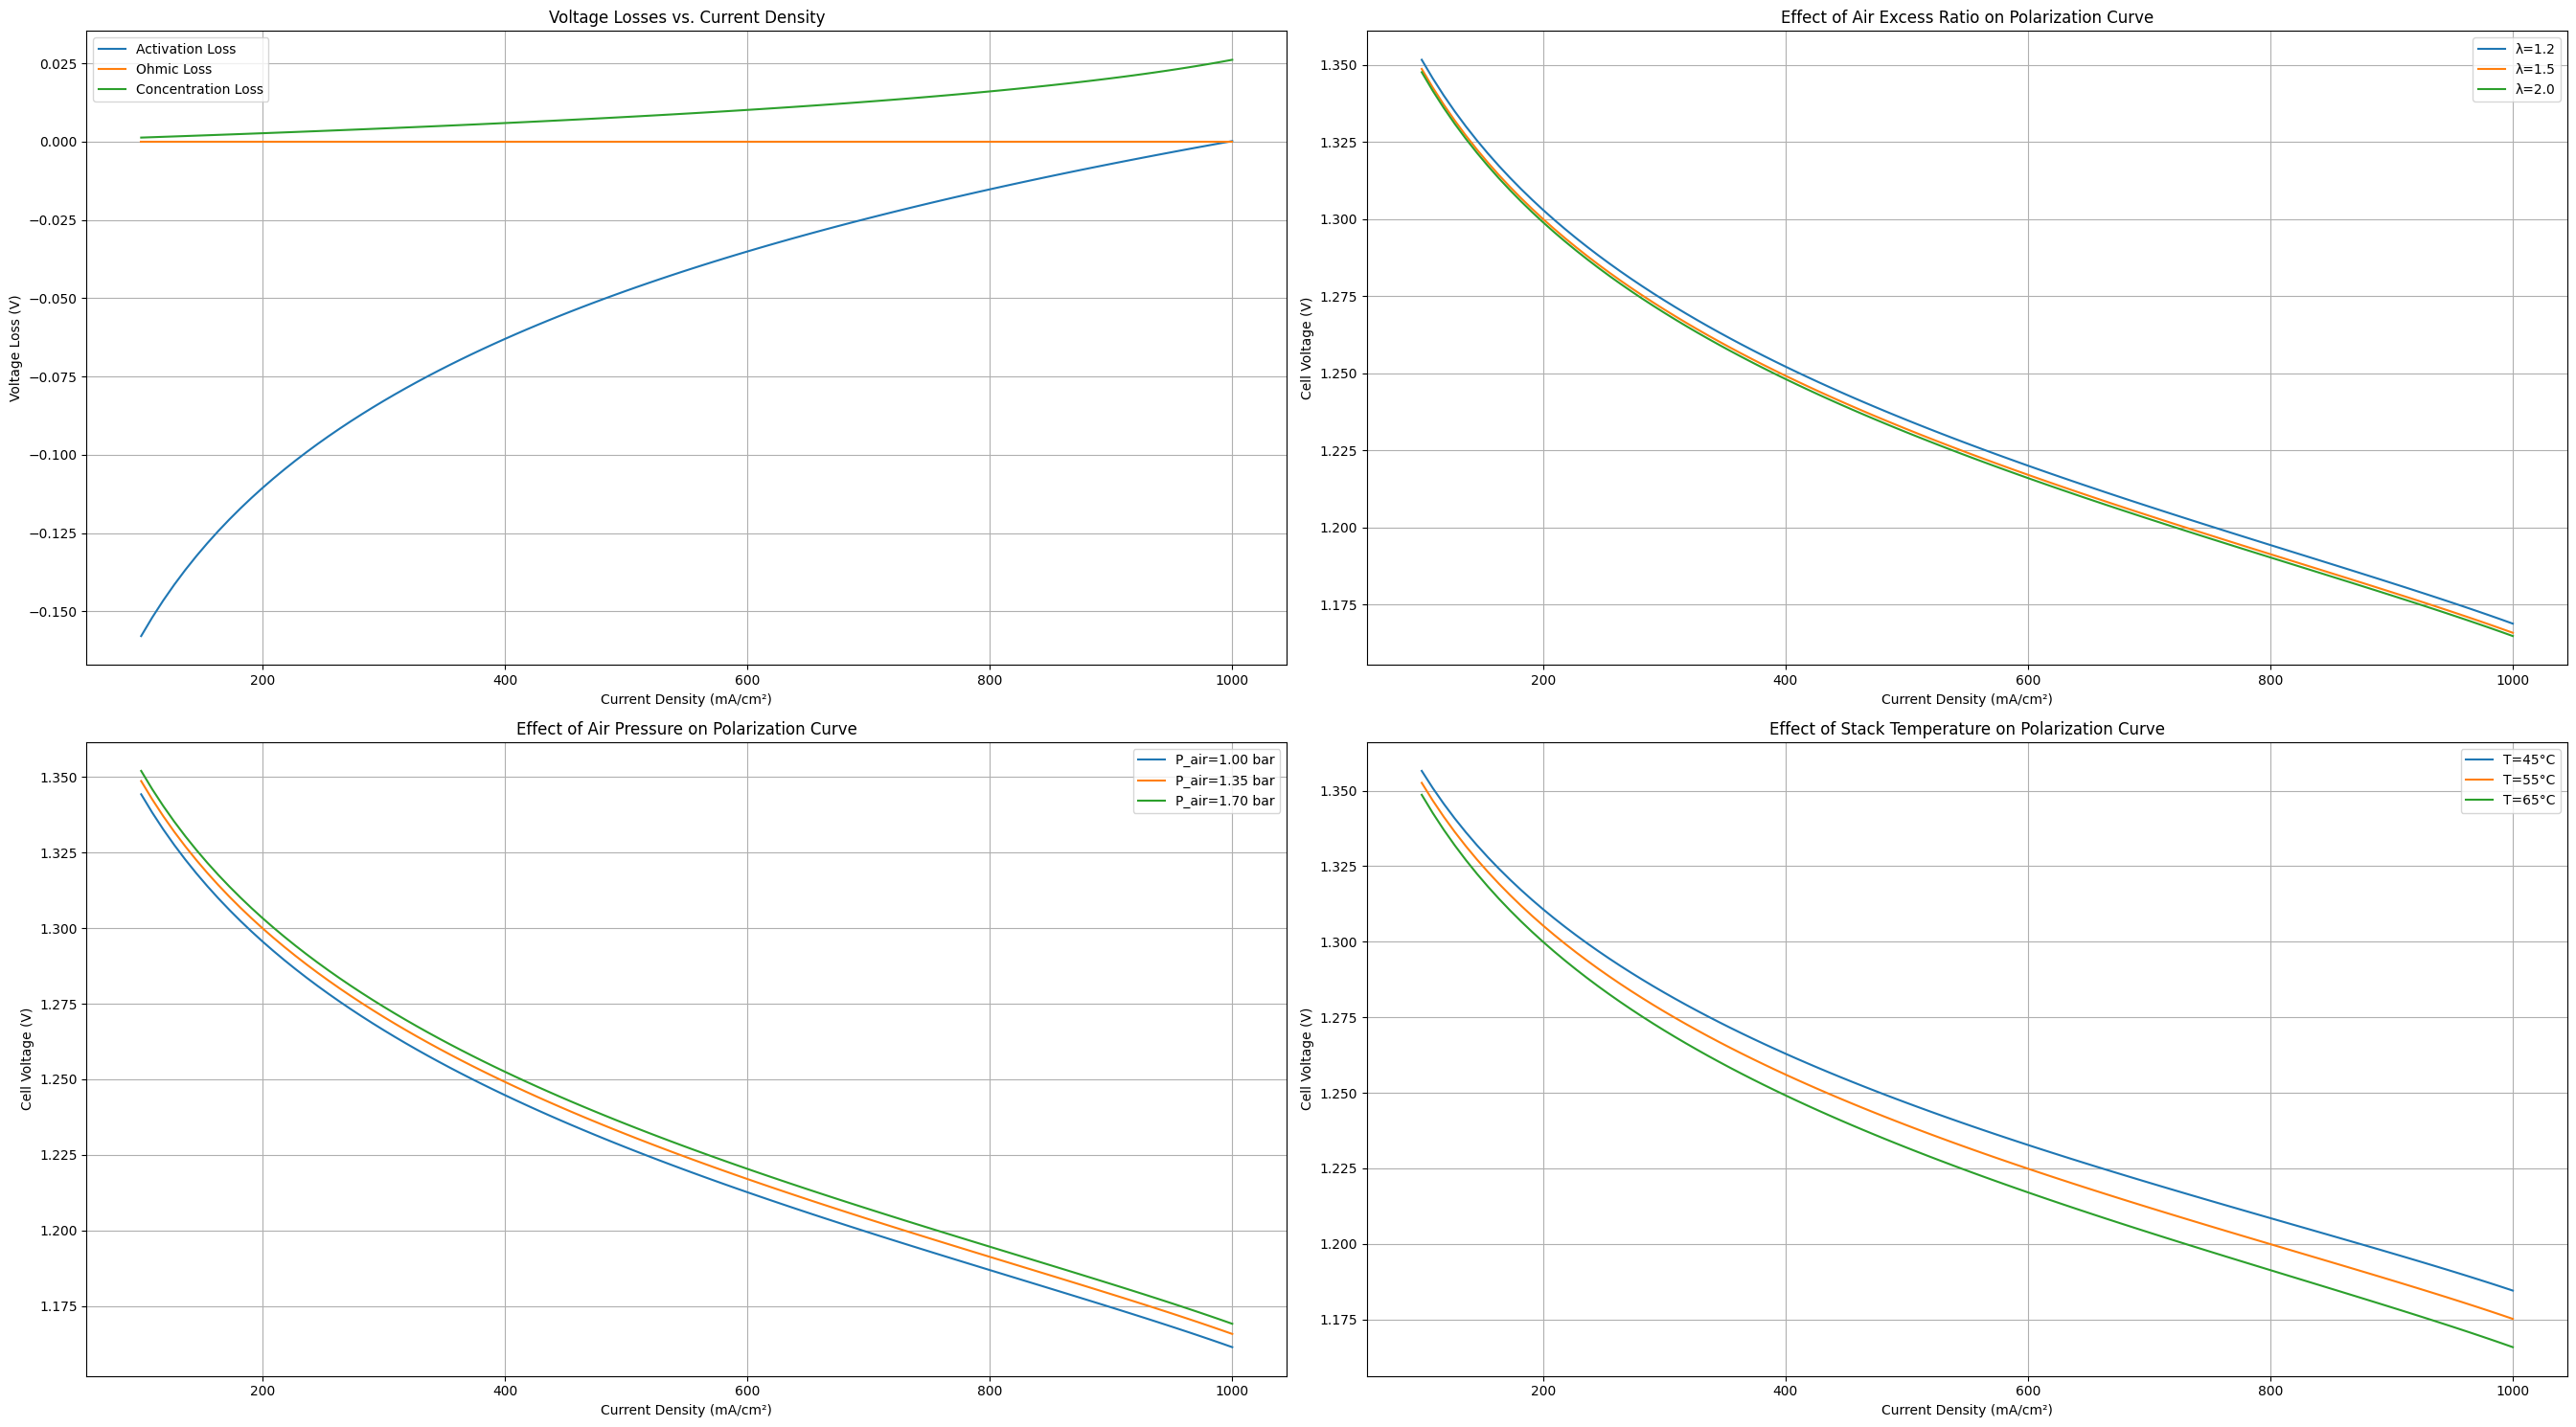

In [49]:

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(27, 15))  # Adjust figsize for better visualization
axs = axs.flatten()  # Flatten the 2D array of subplots for easier indexing

# --- 2. Individual Voltage Losses ---
axs[0].plot(current_density * 1000, V_act, label='Activation Loss')
axs[0].plot(current_density * 1000, V_ohm, label='Ohmic Loss')
axs[0].plot(current_density * 1000, V_conc, label='Concentration Loss')
axs[0].set_xlabel('Current Density (mA/cm²)')
axs[0].set_ylabel('Voltage Loss (V)')
axs[0].set_title('Voltage Losses vs. Current Density')
axs[0].grid(True)
axs[0].legend()

# --- 3. Effect of Air Excess Ratio (lambda) ---
for l in [1.2, 1.5, 2.0]:
    pdrop = pdrop_stack(current_density, l)
    P_O2 = oxygen_partial_pressure(P_air, pdrop, l)
    E_OC = nernst_voltage(T, P_O2)
    voltage = E_OC - activation_loss(current_density, T) - ohmic_loss(current_density, T) - concentration_loss(current_density, T)
    axs[1].plot(current_density * 1000, voltage, label=f'λ={l}')
axs[1].set_xlabel('Current Density (mA/cm²)')
axs[1].set_ylabel('Cell Voltage (V)')
axs[1].set_title('Effect of Air Excess Ratio on Polarization Curve')
axs[1].grid(True)
axs[1].legend()

# --- 4. Effect of Air Pressure ---
for p in [1.0e5, 1.35e5, 1.7e5]:  # 1, 1.35, 1.7 bar
    pdrop = pdrop_stack(current_density, lambda_air)
    P_O2 = oxygen_partial_pressure(p, pdrop, lambda_air)
    E_OC = nernst_voltage(T, P_O2)
    voltage = E_OC - activation_loss(current_density, T) - ohmic_loss(current_density, T) - concentration_loss(current_density, T)
    axs[2].plot(current_density * 1000, voltage, label=f'P_air={p/1e5:.2f} bar')
axs[2].set_xlabel('Current Density (mA/cm²)')
axs[2].set_ylabel('Cell Voltage (V)')
axs[2].set_title('Effect of Air Pressure on Polarization Curve')
axs[2].grid(True)
axs[2].legend()

# --- 5. Effect of Stack Temperature ---
for temp in [45+273.15, 55+273.15, 65+273.15]:  # 45, 55, 65°C
    pdrop = pdrop_stack(current_density, lambda_air)
    P_O2 = oxygen_partial_pressure(P_air, pdrop, lambda_air)
    E_OC = nernst_voltage(temp, P_O2)
    voltage = E_OC - activation_loss(current_density, temp) - ohmic_loss(current_density, temp) - concentration_loss(current_density, temp)
    axs[3].plot(current_density * 1000, voltage, label=f'T={temp-273.15:.0f}°C')
axs[3].set_xlabel('Current Density (mA/cm²)')
axs[3].set_ylabel('Cell Voltage (V)')
axs[3].set_title('Effect of Stack Temperature on Polarization Curve')
axs[3].grid(True)
axs[3].legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()